In [98]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from miga.const import ID2LABELS_SMG_SHORT as ID2LABELS
from collections import Counter

In [99]:
path_to_folder = r'C:\Users\gutzc\GitHub\human_micro_gesture_classifier\scripts\miga_smg\videomae_vit_base_patch16_224_kinetic_400_densepose_dual\dataset'

In [100]:
df_train_orig = pd.read_csv(osp.join(path_to_folder, 'train.csv'), index_col=0)
df_val_orig = pd.read_csv(osp.join(path_to_folder, 'val.csv'), index_col=0)
df_val_orig['labels'] = df_val_orig['labels'].apply(lambda x: ast.literal_eval(x))
df_train_orig['labels'] = df_train_orig['labels'].apply(lambda x: ast.literal_eval(x))

df_val_orig['metadata'] = df_val_orig['metadata'].apply(lambda x: ast.literal_eval(x))
df_train_orig['metadata'] = df_train_orig['metadata'].apply(lambda x: ast.literal_eval(x))

In [134]:
original_columns = df_train_orig.columns

In [102]:
df_val =  df_val_orig.copy()
df_train =  df_train_orig.copy()

df = pd.concat([df_val, df_train])

df['labels_ind'] = df['labels'].apply(lambda x:np.argmax(x))
metadata_1 = df['metadata'].values[0]
metadata_keys = metadata_1.keys()
for col in metadata_1.keys():
    if col not in df.columns:
        df[col] = df['metadata'].apply(lambda x: x[col])
        
df['file_id'] = df['sample_id'].apply(lambda x: x.split('_')[0])
df['short_labels_txt'] = df['labels_ind'].apply(lambda x: ID2LABELS[x+1])

In [103]:
df.columns

Index(['filenames', 'folder_name', 'durations', 'view', 'labels', 'metadata',
       'labels_ind', 'sample_id', 'start_frame', 'end_frame', 'label_txt',
       'file_id', 'short_labels_txt'],
      dtype='object')

C:\Users\gutzc\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


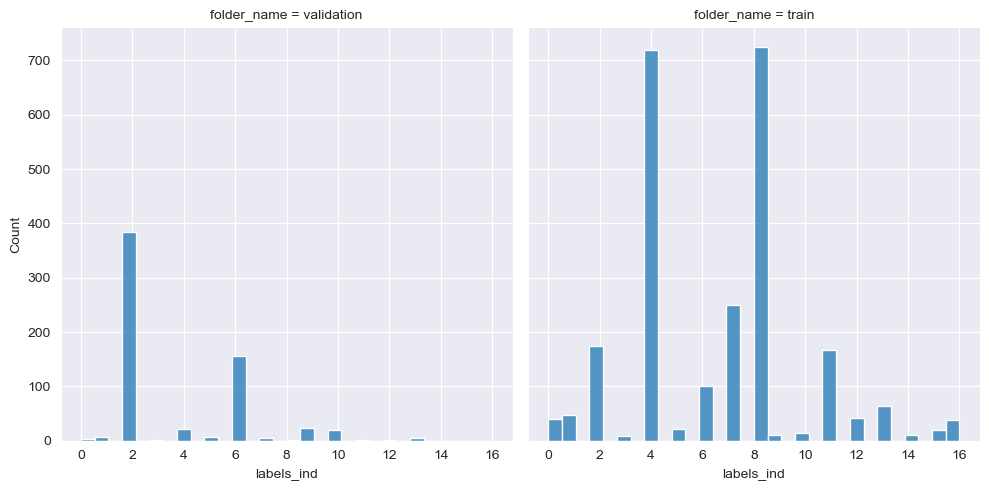

In [104]:
sns.displot(data=df, x='labels_ind', col='folder_name')

In [105]:
# validate validation data
from collections import Counter
validation_counts = Counter(df.loc[df['folder_name']=='validation']['labels_ind'])
train_counts = Counter(df.loc[df['folder_name']=='train']['labels_ind'])



In [106]:
df_counter = pd.DataFrame([validation_counts,train_counts]).transpose()
df_counter.columns = ['validation','train']
df_counter = df_counter.sort_index()
df_counter

,validation,train
0,3.0,40.0
1,7.0,48.0
2,384.0,175.0
3,2.0,9.0
4,22.0,720.0
5,6.0,21.0
6,156.0,101.0
7,5.0,249.0
8,2.0,724.0
9,23.0,11.0


In [107]:
# reshuffle dataset and resample

df.head(5)

,filenames,folder_name,durations,view,labels,metadata,labels_ind,sample_id,start_frame,end_frame,label_txt,file_id,short_labels_txt
0,Sample0031_color_0001.mp4,validation,89,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0001', 'start_frame': 940,...",2,0031_0001,940,1029,Moving legs,0031,Fold_Arms
1,Sample0031_color_0002.mp4,validation,84,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0002', 'start_frame': 1245...",2,0031_0002,1245,1329,Moving legs,0031,Fold_Arms
2,Sample0031_color_0003.mp4,validation,105,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0003', 'start_frame': 1482...",2,0031_0003,1482,1587,Moving legs,0031,Fold_Arms
3,Sample0031_color_0004.mp4,validation,82,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0004', 'start_frame': 1744...",2,0031_0004,1744,1826,Moving legs,0031,Fold_Arms
4,Sample0031_color_0005.mp4,validation,68,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0005', 'start_frame': 1865...",2,0031_0005,1865,1933,Moving legs,0031,Fold_Arms


In [189]:
# DO NOT ADD ANYTHING TO 4 AND 8
MIN_SPACE = 1
def combine_labels(df_e):
    
    df_e = df_e.copy()
    start_frame = df_e['start_frame'].values
    end_frame = df_e['end_frame'].values
    labels_onehot = df_e['labels'].values
    labels_ind = df_e['labels_ind'].values
    
    # df_sorted = df.sort_values(by='sample_id')
    # start_frame = df_sorted['start_frame'].values
    # end_frame = df_sorted['end_frame'].values
    
    intervals = start_frame[1:] - end_frame[:-1]
    new_labels_ind = [[a] for a in labels_ind]
    for i in range(1,len(intervals)):
        if intervals[i] < MIN_SPACE:
            # DO NOT ADD ANYTHING TO 4 AND 8
            
            # update labels and update one hots
            if labels_ind[i] not in new_labels_ind[i-1] and labels_ind[i-1] not in [4, 8]:
                new_labels_ind[i-1].append(labels_ind[i])
                labels_onehot[i-1][labels_ind[i]] = 1

                
            if labels_ind[i-1] not in new_labels_ind[i] and new_labels_ind[i-1] not in [4, 8]:
                new_labels_ind[i].append(labels_ind[i-1])
                labels_onehot[i][labels_ind[i-1]] = 1
            
    # update df_g
    df_e['new_labels_ind'] = new_labels_ind
    df_e['labels'] = labels_onehot
    return df_e


df_g = list(df.groupby(['file_id']))

all_new_df_list = []
for e, df_e in df_g:
    try:
        all_new_df_list.append(combine_labels(df_e))
    except:
        print(e)
        
    
df = pd.concat(all_new_df_list)

(array([103., 573., 750., 284., 259., 774., 204.,  45.,  80.,  63.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

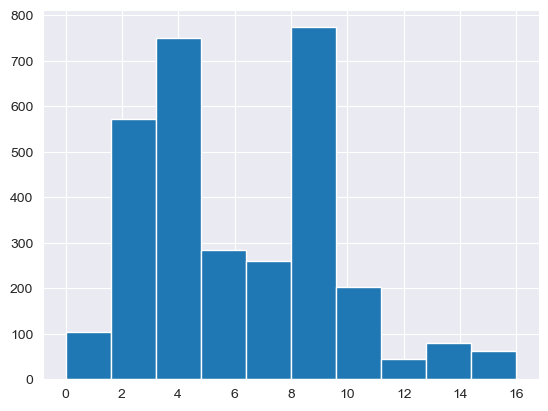

In [190]:
# see new dist
all_labels = df['new_labels_ind'].values
all_labels = [a for sub in all_labels for a in sub]
plt.hist(all_labels)

In [191]:
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)


X = df['filenames']
y = df['labels_ind']
# X_res, y_res = sm.fit_resample(X, y)
X_train_inds, X_test_inds, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [192]:
X_train_inds

105    Sample0005_color_0106.mp4
97     Sample0005_color_0098.mp4
34     Sample0028_color_0035.mp4
65     Sample0034_color_0066.mp4
7      Sample0024_color_0008.mp4
                 ...            
63     Sample0008_color_0064.mp4
74     Sample0004_color_0075.mp4
82     Sample0008_color_0083.mp4
6      Sample0003_color_0007.mp4
8      Sample0001_color_0009.mp4
Name: filenames, Length: 2471, dtype: object

In [193]:
validation_counts = Counter(y_test)
train_counts = Counter(y_train)


df_counter = pd.DataFrame([validation_counts,train_counts]).transpose()
df_counter.columns = ['validation','train']
df_counter = df_counter.sort_index()
df_counter

,validation,train
0,11,32
1,13,42
2,112,447
3,3,8
4,147,595
5,6,21
6,40,217
7,48,206
8,144,582
9,9,25


In [194]:
# validation_counts = Counter(y_train)
# train_counts = Counter(y_test)
# 
# df_counter = pd.DataFrame([validation_counts,train_counts]).transpose()
# df_counter.columns = ['validation','train']
# df_counter = df_counter.sort_index()
# df_counter

C:\Users\gutzc\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


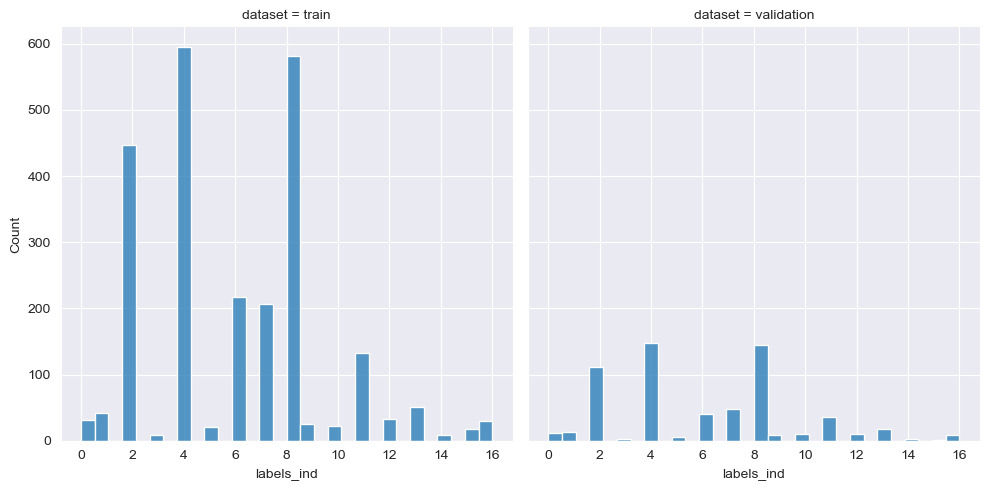

In [195]:
df_new = df.copy()
df_new['dataset'] = 'validation'
df_new.loc[df_new['filenames'].isin(X_train_inds),'dataset'] = 'train'
sns.displot(data=df_new, x='labels_ind', col='dataset')


In [196]:
# actual labels

flatten = lambda arr: [a for sub in arr for a in sub]

y_test = flatten(df_new.loc[df_new['dataset']=='validation']['new_labels_ind'].values)
y_train = flatten(df_new.loc[df_new['dataset']=='train']['new_labels_ind'].values)

validation_counts = Counter(y_test)
train_counts = Counter(y_train)


df_counter = pd.DataFrame([validation_counts,train_counts]).transpose()
df_counter.columns = ['validation','train']
df_counter = df_counter.sort_index()
df_counter

,validation,train
0,12,33
1,14,44
2,112,450
3,3,8
4,148,602
5,6,21
6,40,217
7,50,209
8,145,594
9,10,25


(array([ 77., 458., 602., 238., 209., 619., 157.,  34.,  61.,  53.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

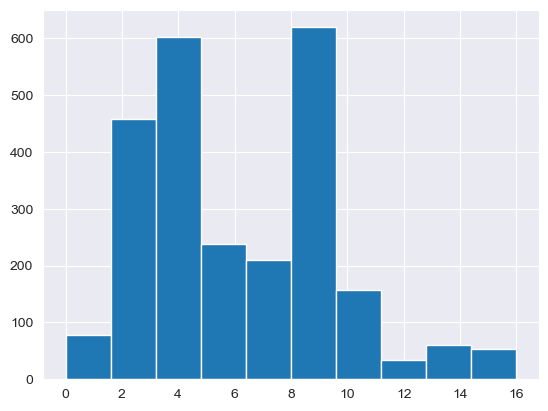

In [197]:
plt.hist(y_train)

In [198]:
df_new.loc[df_new['new_labels_ind'].apply(lambda x: len(x))>1]

,filenames,folder_name,durations,view,labels,metadata,labels_ind,sample_id,start_frame,end_frame,label_txt,file_id,short_labels_txt,new_labels_ind,dataset
17,Sample0001_color_0018.mp4,train,50,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0....","{'sample_id': '0001_0018', 'start_frame': 1449...",11,0001_0018,14499,14549,Scratching or touching facial parts other than...,0001,Scratch_Fase_not_eyes,"[11, 8]",train
18,Sample0001_color_0019.mp4,train,232,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_0019', 'start_frame': 1461...",8,0001_0019,14618,14850,Arms akimbo,0001,Arms_akimbo,"[8, 11]",train
0,Sample0002_color_0001.mp4,train,26,center,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0....","{'sample_id': '0002_0001', 'start_frame': 136,...",0,0002_0001,136,162,Turtling neck and shoulder,0002,Shrug,"[0, 8]",train
1,Sample0002_color_0002.mp4,train,34,center,"[1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0....","{'sample_id': '0002_0002', 'start_frame': 163,...",8,0002_0002,163,197,Arms akimbo,0002,Arms_akimbo,"[8, 0]",validation
7,Sample0002_color_0008.mp4,train,90,center,"[1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0....","{'sample_id': '0002_0008', 'start_frame': 941,...",7,0002_0008,941,1031,Rubbing hands and crossing finger,0002,Rub_Hands,"[7, 0]",train
8,Sample0002_color_0009.mp4,train,51,center,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 0....","{'sample_id': '0002_0009', 'start_frame': 1074...",0,0002_0009,1074,1125,Turtling neck and shoulder,0002,Shrug,"[0, 7]",train
81,Sample0004_color_0082.mp4,train,31,center,"[0.0, 1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","{'sample_id': '0004_0082', 'start_frame': 2351...",2,0004_0082,23516,23547,Folding arms,0004,Fold_Arms,"[2, 1]",train
82,Sample0004_color_0083.mp4,train,36,center,"[0.0, 1.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","{'sample_id': '0004_0083', 'start_frame': 2367...",1,0004_0083,23676,23712,Rubbing eyes and forehead,0004,Rub_Eyes,"[1, 2]",train
89,Sample0004_color_0090.mp4,train,153,center,"[0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 1, 0.0,...","{'sample_id': '0004_0090', 'start_frame': 2432...",11,0004_0090,24321,24474,Scratching or touching facial parts other than...,0004,Scratch_Fase_not_eyes,"[11, 4]",train
90,Sample0004_color_0091.mp4,train,72,center,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0004_0091', 'start_frame': 2447...",4,0004_0091,24476,24548,Moving legs,0004,Move_Legs,"[4, 11]",train


In [163]:
[ID2LABELS[a+1] for a in [11, 8, 1]]

['Scratch_Fase_not_eyes', 'Arms_akimbo', 'Rub_Eyes']

In [185]:
df_new.loc[df_new['filenames'].isin([f'Sample0001_color_00{i}.mp4' for i in [18,19,20]])][['filenames','labels_ind','short_labels_txt']]

,filenames,labels_ind,short_labels_txt
17,Sample0001_color_0018.mp4,11,Scratch_Fase_not_eyes
18,Sample0001_color_0019.mp4,8,Arms_akimbo
19,Sample0001_color_0020.mp4,8,Arms_akimbo


In [143]:
### Save new dataset

new_val_df = df_new.loc[df_new['dataset']=='validation']
new_train_df = df_new.loc[df_new['dataset']=='train']

In [151]:
new_val_df.loc[new_val_df['labels'].apply(lambda x: np.sum(x))>1]

,filenames,folder_name,durations,view,labels,metadata,labels_ind,sample_id,start_frame,end_frame,label_txt,file_id,short_labels_txt,new_labels_ind,dataset
18,Sample0001_color_0019.mp4,train,232,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_0019', 'start_frame': 1461...",8,0001_0019,14618,14850,Arms akimbo,0001,Arms_akimbo,"[8, 11]",validation
7,Sample0003_color_0008.mp4,train,62,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0....","{'sample_id': '0003_0008', 'start_frame': 9053...",11,0003_0008,9053,9115,Scratching or touching facial parts other than...,0003,Scratch_Fase_not_eyes,"[11, 8]",validation
17,Sample0004_color_0018.mp4,train,121,center,"[0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 1.0, 0....","{'sample_id': '0004_0018', 'start_frame': 8103...",8,0004_0018,8103,8224,Arms akimbo,0004,Arms_akimbo,"[8, 4]",validation
32,Sample0004_color_0033.mp4,train,125,center,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0004_0033', 'start_frame': 9948...",1,0004_0033,9948,10073,Rubbing eyes and forehead,0004,Rub_Eyes,"[1, 11, 15]",validation
52,Sample0004_color_0053.mp4,train,16,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0....","{'sample_id': '0004_0053', 'start_frame': 1851...",13,0004_0053,18511,18527,Holding arms,0004,Hold_Arms,"[13, 8]",validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,Sample0035_color_0042.mp4,validation,29,center,"[0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","{'sample_id': '0035_0042', 'start_frame': 1291...",13,0035_0042,12917,12946,Illustrative hand gestures,0035,Hold_Arms,"[13, 2]",validation
59,Sample0035_color_0060.mp4,validation,29,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1.0, 0.0, 0....","{'sample_id': '0035_0060', 'start_frame': 1451...",7,0035_0060,14519,14548,Crossing legs,0035,Rub_Hands,"[7, 6]",validation
60,Sample0035_color_0061.mp4,validation,44,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1, 0.0, 0....","{'sample_id': '0035_0061', 'start_frame': 1481...",6,0035_0061,14815,14859,Arms akimbo,0035,Fold_Arms_BB,"[6, 7]",validation
74,Sample0035_color_0075.mp4,validation,93,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 0....","{'sample_id': '0035_0075', 'start_frame': 1654...",10,0035_0075,16542,16635,Playing or adjusting hair,0035,Scratch_Body,"[10, 7]",validation


In [199]:
[ID2LABELS[a+1] for a in [1, 11, 15]]

['Rub_Eyes', 'Scratch_Fase_not_eyes', 'Play_Object']

In [200]:
#### THIS IS NOT WORKING